# 1. Import topologies and initialize the network

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tqdm import tqdm
from random import sample

from swarm_sim import *

%matplotlib inline 

In [2]:
CONNECTION_RANGE = 30000
NB_NODES = 100
T_HIGH = 1505
T_AVG = 400
T_LOW = 816

df_low = pd.read_csv('../data/Topologies/topology_low.csv', sep=',', header=0, index_col='sat_id')
df_avg = pd.read_csv('../data/Topologies/topology_avg.csv', sep=',', header=0, index_col='sat_id')
df_high = pd.read_csv('../data/Topologies/topology_high.csv', sep=',', header=0, index_col='sat_id')

df_low.head()

,x,y,z
sat_id,,,
0,641794.913967,9.023602e+05,4.474116e+06
1,579336.565781,1.027713e+06,4.477344e+06
2,650020.048393,1.011238e+06,4.433289e+06
3,512224.984133,9.931288e+05,4.504896e+06
4,695578.271553,9.682931e+05,4.507019e+06


In [3]:
# Convert DataFrame to Swarm object

swarm_topo = {}

swarm_topo[T_LOW] = Swarm(
    connection_range=CONNECTION_RANGE,
    nodes=[Node(i, df_low.iloc[i].x, df_low.iloc[i].y, df_low.iloc[i].z) for i in list(df_low.index.values)]
)

swarm_topo[T_AVG] = Swarm(
    connection_range=CONNECTION_RANGE,
    nodes=[Node(i, df_avg.iloc[i].x, df_avg.iloc[i].y, df_avg.iloc[i].z) for i in list(df_avg.index.values)]
)

swarm_topo[T_HIGH] = Swarm(
    connection_range=CONNECTION_RANGE,
    nodes=[Node(i, df_high.iloc[i].x, df_high.iloc[i].y, df_high.iloc[i].z) for i in list(df_high.index.values)]
)

In [5]:
# Assign group to nodes (MDRW)

def MDRW(swarm, n=10, s=1):
    sources = sample(swarm.nodes, n) # Initial random sources
    
    groups = {} # Dict(group ID:list(nodes))
    for group_id, src in enumerate(sources): # Initialize swarms
        src.set_group(group_id)
        groups[group_id] = [src]
    free_nodes = [n for n in swarm.nodes if n.group==-1]
    while free_nodes: # Spread paths
        for group_id in groups.keys():
            n_i = groups[group_id][-1] # Current node
            free_neighbors = set(free_nodes).intersection(n_i.neighbors)
            if free_neighbors: # At least one unassigned neighbor
                n_j = n_i.random_walk(group_id) # Next node
            else:
                n_j = swarm.random_jump(s) # If no neighbor, perform random jump in the graph
            n_j.set_group(n_i.group)
            groups[group_id].append(n_j)
            free_nodes.remove(n_j)
    return groups

In [61]:
swarm = swarm_topo[T_AVG]

swarm.reset_groups()
groups = MDRW(swarm, n=10)

for id, group in groups.items():
    print('Group '+str(id)+':', [n.id for n in group])

Group 0: [72, 41, 40, 74, 53, 28, 35, 21, 86, 70]
Group 1: [97, 7, 24, 17, 29, 64, 85, 98, 47, 71]
Group 2: [8, 1, 84, 5, 11, 30, 44, 31, 54, 75]
Group 3: [32, 19, 50, 18, 33, 42, 45, 2, 68, 9]
Group 4: [15, 20, 27, 34, 43, 3, 93, 37, 59, 76]
Group 5: [63, 52, 51, 78, 25, 94, 10, 88, 13, 4]
Group 6: [57, 66, 99, 87, 16, 90, 0, 62, 65, 77]
Group 7: [60, 73, 55, 67, 14, 26, 96, 38, 79, 95]
Group 8: [83, 23, 12, 39, 6, 22, 56, 69, 36, 80]
Group 9: [48, 81, 46, 82, 91, 49, 89, 58, 61, 92]


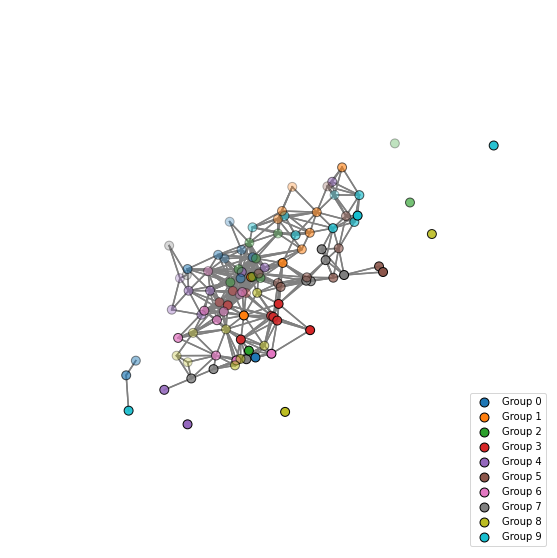

In [64]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.axis('off')

for node in swarm.nodes:
    for n in node.neighbors:
        if n in swarm.nodes:
            ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c='gray')

for id,group in groups.items():
    x_data = [node.x for node in group]
    y_data = [node.y for node in group]
    z_data = [node.z for node in group]
    ax.scatter(x_data, y_data, z_data, s=80, edgecolors='black', label='Group '+str(id))
            
ax.legend(loc='lower right')
                


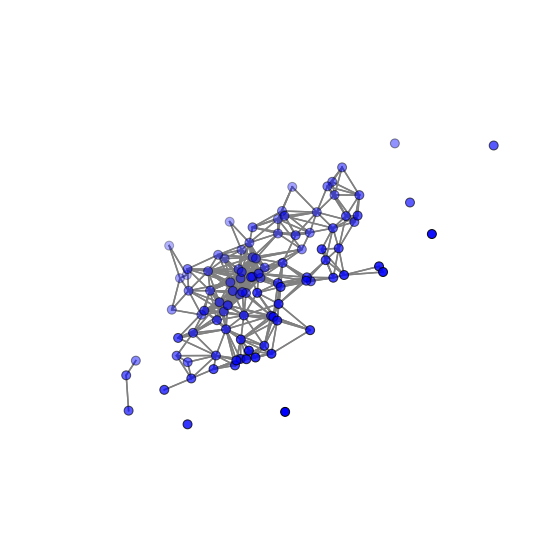

In [66]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.grid(False)
ax.axis('off')

x_data = [node.x for node in swarm.nodes]
y_data = [node.y for node in swarm.nodes]
z_data = [node.z for node in swarm.nodes]
ax.scatter(x_data, y_data, z_data, c='blue', s=80, edgecolors='black')

for node in swarm.nodes:
    for n in node.neighbors:
        if n in swarm.nodes:
            ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c='gray')

In [4]:
# Establish ISL within the network
neighbor_matrix = {}

with tqdm(total=len(swarm_topo.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_topo.keys():
        neighbor_matrix[t] = swarm_topo[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix: 100%|██████████| 3/3 [00:00<00:00, 71.62it/s]


In [6]:
swarm_topo[T_LOW].reset_groups()
groups = MDRW(swarm_topo[T_LOW], n=10)

for id, group in groups.items():
    print('Group '+str(id)+':', [n.id for n in group])

Group 0: [66, 77, 87, 80, 72, 30, 71, 6, 54, 76]
Group 1: [31, 89, 17, 11, 2, 14, 29, 10, 55, 81]
Group 2: [84, 1, 26, 35, 12, 65, 57, 9, 59, 83]
Group 3: [88, 24, 98, 78, 50, 51, 19, 73, 94, 3]
Group 4: [36, 41, 5, 52, 46, 8, 37, 43, 96, 85]
Group 5: [44, 40, 48, 60, 68, 97, 62, 70, 75, 0]
Group 6: [15, 18, 74, 20, 28, 21, 38, 47, 4, 92]
Group 7: [95, 79, 22, 45, 34, 90, 56, 49, 32, 86]
Group 8: [39, 42, 33, 27, 16, 23, 69, 53, 61, 93]
Group 9: [58, 91, 82, 64, 13, 25, 7, 67, 63, 99]


# 2. Find all shortest paths using NetworkX

In [7]:
import networkx as nx

In [37]:
def add_row_sp(dict, src_id, dst_id, paths):
    dict['Source'].append(src_id)
    dict['Dest'].append(dst_id)
    dict['Number of shortest paths'].append(len(paths))
    dict['SPL'].append(len(paths[0]))

In [38]:
swarm = swarm_topo[T_LOW]
graph = swarm.swarm_to_nxgraph()
print(graph)

shortest_paths = {
    'Source':[],
    'Dest':[],
    'Number of shortest paths':[],
    'SPL':[]
}

visited_pairs = []

for src_id in graph.nodes:
    for dst_id in graph.nodes:
        if set((src_id,dst_id)) not in visited_pairs:
            visited_pairs.append(set((src_id,dst_id)))
            if dst_id != src_id and nx.has_path(graph, src_id, dst_id):
                paths = []
                for path in nx.all_shortest_paths(graph, source=src_id, target=dst_id):
                    paths.append(path)
                add_row_sp(shortest_paths, src_id, dst_id, paths)

Graph with 100 nodes and 265 edges


In [39]:
df_sp = pd.DataFrame(shortest_paths)
df_sp

,Source,Dest,Number of shortest paths,SPL
0,0,1,4,7
1,0,2,8,7
2,0,5,22,7
3,0,6,4,5
4,0,7,2,5
...,...,...,...,...
3318,95,97,2,5
3319,95,98,1,7
3320,96,97,1,6
3321,96,98,17,7


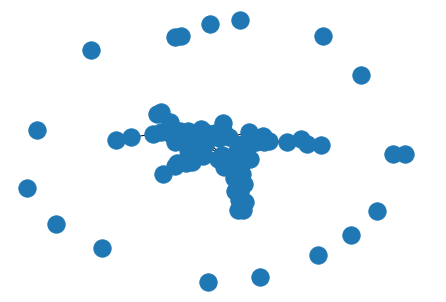

In [52]:
nx.draw(graph)

# 3. Analyze betweeness centrality distribution

In [18]:
bc_dict = nx.betweenness_centrality(graph)

In [23]:
df_bc = pd.DataFrame.from_dict(bc_dict, orient='index', columns=['Betweeness centrality'])
df_bc

,Betweeness centrality
0,0.000000
1,0.005854
2,0.000000
3,0.000000
4,0.000000
...,...
95,0.016491
96,0.016491
97,0.055710
98,0.036040


<AxesSubplot:ylabel='Betweeness centrality'>

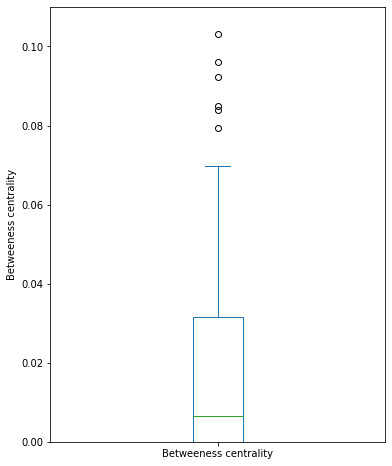

In [25]:
df_bc.plot(
    kind='box', 
    figsize=(6,8),
    ylim=(0,0.11),
    xlabel='Nodes',
    ylabel='Betweeness centrality')

# 4. Analyze impact of nodes removal on shortest paths

In [45]:
thresh = df_bc['Betweeness centrality'].quantile(0.9)
print(thresh)
top_nodes = [nid for nid,bc in bc_dict.items() if bc>=thresh]
top_nodes

0.058890275881651945


[5, 17, 27, 39, 51, 52, 68, 71, 78, 87]

In [46]:
simu_graph = graph.copy()
simu_graph.remove_nodes_from(top_nodes)
print(graph)
print(simu_graph)

Graph with 100 nodes and 265 edges
Graph with 90 nodes and 175 edges


In [47]:
shortest_paths = {
    'Source':[],
    'Dest':[],
    'Number of shortest paths':[],
    'SPL':[]
}

visited_pairs = []

for src_id in simu_graph.nodes:
    for dst_id in simu_graph.nodes:
        if set((src_id,dst_id)) not in visited_pairs:
            visited_pairs.append(set((src_id,dst_id)))
            if dst_id != src_id and nx.has_path(simu_graph, src_id, dst_id):
                paths = []
                for path in nx.all_shortest_paths(simu_graph, source=src_id, target=dst_id):
                    paths.append(path)
                add_row_sp(shortest_paths, src_id, dst_id, paths)

In [48]:
df_sp_faulty = pd.DataFrame(shortest_paths)
df_sp_faulty

,Source,Dest,Number of shortest paths,SPL
0,0,6,4,5
1,0,7,2,5
2,0,9,2,4
3,0,12,1,4
4,0,14,4,6
...,...,...,...,...
1273,93,97,1,4
1274,94,95,1,6
1275,94,97,1,4
1276,95,97,1,5


In [51]:
print('Average SPL:', df_sp['SPL'].mean(), '\tConnectivity:', len(df_sp.index)/4950)
print('Average SPL after fault:', df_sp_faulty['SPL'].mean(), '\tConnectivity:', len(df_sp_faulty.index)/4950)

Average SPL: 4.9416190189587725 	Connectivity: 0.6713131313131313
Average SPL after fault: 4.402190923317684 	Connectivity: 0.2581818181818182
